# 3) Baseline Search & Metrics

In this notebook we create a query set and run a `best_match` query with a reasonable set of search fields and weights.

In addition to the ESCI product data we are making use of the judgements that we map to numeric values.

For each query we calculate search metrics and an average over all queries.

This gives us a baseline that we can use as our foundation when exploring different hybrid search configurations in the next notebook.

In [64]:
import pandas as pd
import numpy as np
import mercury as mr
import requests
import json
import plotly.express as px
import plotly.io as pio
from opensearchpy import OpenSearch
from tqdm.notebook import tqdm_notebook

In [65]:
DATA_DIR = '/Users/danielwrigley/work/Testing/git_repos/esci-data/shopping_queries_dataset/'

In [66]:
df_examples = pd.read_parquet(DATA_DIR + '/shopping_queries_dataset_examples.parquet')

In [67]:
# We only use English queries for now
df_queries_us = df_examples[df_examples['product_locale'] == 'us']

## Query set
We randomly sampled two query sets based on the ESCI dataset:

* one large query set with 5000 queries
* one small query set with 250 queries

Both are split into training (80 %) and test (20 %) set.

In [68]:
# Set the boolean value accordingly to use either the small (small_b = True) or the large dataset (small_b = False).
small_b = True

if small_b:
    df_train = pd.read_csv('../data/query_train_small.csv')
    df_test = pd.read_csv('../data/query_test_small.csv')
if not small_b:
    df_train = pd.read_csv('../data/query_train.csv')
    df_test = pd.read_csv('../data/query_test.csv')

In [69]:
df_query_set = pd.concat([df_train, df_test])

## Judgments
The judgments dataset has a row per query instance and document and has the following columns:

* datetime: date of query/document instance
* query_id: identifier of query instance
* query: the query
* document: identifier of a document result
* judgment: Here we use the proposed ESCI mapping for DCG: `{"E": 0, "S": 1, "C": 2, "I": 3}` 

In [70]:
# Select judgments
# Map esci_label to score
# create judgments per day in range
# create noise in score

label_num = {"E": 0, "S": 1, "C": 2, "I": 3}
label_score = [3, 2, 1, 0]
#label_score = [1, 0.1, 0.01, 0]

def label_to_score(label):
    return label_score[label_num[label]]

df_judge = df_examples[df_examples["query"].isin(set(df_query_set["query_string"].values))].copy()
df_judge["judgment"] = df_judge.esci_label.apply(lambda x: label_to_score(x))
df_judge["document"] = df_judge.product_id
df_judge = df_judge[["query", "document", "judgment"]].reset_index(drop=True)
df_judge.head(3)

,query,document,judgment
0,09 g6 wheel not cover grey,B07WSBV4PK,0
1,09 g6 wheel not cover grey,B07WS62XTM,0
2,09 g6 wheel not cover grey,B07VLX8QWK,0


# Transform the queries and judgments

### Group by queries and export to a file with the index to have queries and query ids

In [71]:
df_queries = df_judge.groupby(by='query', as_index=False).agg({
    'judgment': ['count']
})
df_query_idx = df_queries['query']

In [72]:
df_queries

,query,judgment
,,count
0,09 g6 wheel not cover grey,39
1,1 1/4 pop up bathroom sink drain without overflow,40
2,1 ‘ velcro without adhesive for sewing,40
3,1.5 inch heel,16
4,1/2 inch binder,53
...,...,...
245,wood arm chair,16
246,work clothes for women,16
247,work vest for men,16


### Go through the queries and update the original ratings with the query ids

In [73]:
df_query_idx = pd.DataFrame(df_query_idx)

In [74]:
df_query_idx = df_query_idx.reset_index().rename(columns={'index': 'idx'})

df_merged = pd.merge(df_judge, df_query_idx, on='query', how='left')
df_merged.columns = ['query', 'docid', 'rating', 'idx']

In [75]:
df_merged

,query,docid,rating,idx
0,09 g6 wheel not cover grey,B07WSBV4PK,0,0
1,09 g6 wheel not cover grey,B07WS62XTM,0,0
2,09 g6 wheel not cover grey,B07VLX8QWK,0,0
3,09 g6 wheel not cover grey,B07WNHR1JT,0,0
4,09 g6 wheel not cover grey,B07WJ3B8ZZ,0,0
...,...,...,...,...
4710,youth size dirt bike helmet,B074W42CDK,3,249
4711,youth size dirt bike helmet,B00Y4G7U7C,3,249
4712,youth size dirt bike helmet,B00RTD45HU,3,249
4713,youth size dirt bike helmet,B07CVKRSRL,3,249


In [76]:
# save the ratings, we need them later
name = '../data/ratings.csv'

df_merged.to_csv(name, sep="\t", header=False, index=False)
df_merged.head(3)

,query,docid,rating,idx
0,09 g6 wheel not cover grey,B07WSBV4PK,0,0
1,09 g6 wheel not cover grey,B07WS62XTM,0,0
2,09 g6 wheel not cover grey,B07VLX8QWK,0,0


## Query OpenSearch with the Baseline Configuration

We use a simple `multi_match` query with a couple of fields and field weights.

This will serve as our baseline. We get the first 10 results for each query we have in `df_judge` and store the results in a DataFrame.
We execute the test set only. This ensures that we have a fair comparison and always compare the metrics of the test set queries against each other.

This gives us a quantification of the quality of the baseline configuration.

We will use this to compare our hybrid search configurations against.

In [77]:
url = "http://localhost:9200/ecommerce/_search"

headers = {
    'Content-Type': 'application/json'
}

df_relevance = pd.DataFrame()

for query in tqdm_notebook(df_query_idx[df_query_idx['query'].isin(df_test['query_string'])].itertuples()):

    payload = {
      "_source": {
        "excludes": [
          "title_embedding"
        ]
      },
      "query": {
        "multi_match" : {
          "type": "best_fields",
          "fields": [
            "product_id^100",
            "product_bullet_point^3",
            "product_color^2",
            "product_brand^5",
            "product_description",
            "product_title^10"
          ],
          "operator":   "and",
          "query":      query[2]
        }
      }
    }

    response = requests.request("POST", url, headers=headers, data=json.dumps(payload)).json()
    
    position = 0
    num_results = response['hits']['total']['value']
    for hit in response['hits']['hits']:
        # create a new row for the DataFrame and append it
        row = { 'query_id' : str(query[1]), 'query_string': query[2], 'product_id' : hit["_id"], 'position' : position, 'num_results' : num_results, 'relevance' : hit["_score"], 'run': 'default' }
    
        new_row_df = pd.DataFrame([row])
        df_relevance = pd.concat([df_relevance, new_row_df], ignore_index=True)
        position += 1
    
# work with two for loops:
# 1) one to iterate over the list of queries and have a query id instead of a query
# 2) another one to iterate over the result sets to have the position of the result in the result set 

# DataFrame with columns:
# query_id: the id of the query
# query string: the query itself
# product_id: the id of the product in the hit list
# position: the position of the product in the result set
# num_results: the number of results - unused for now
# relevance: relevance as given by the search engine
# run: the name of the query run

0it [00:00, ?it/s]

In [78]:
df_relevance.head(3)

,query_id,query_string,product_id,position,num_results,relevance,run
0,1,1 1/4 pop up bathroom sink drain without overflow,B07HQFT7GG,0,91,482.79446,default
1,1,1 1/4 pop up bathroom sink drain without overflow,B08MT7ZDN2,1,91,476.07257,default
2,1,1 1/4 pop up bathroom sink drain without overflow,B08YDL7WPW,2,91,475.76108,default


In [80]:
# Make sure ids are strings - otherwise the merge operation might cause an error
df_relevance['query_id'] = df_relevance['query_id'].astype(str)
df_merged['idx'] = df_merged['idx'].astype(str)
# Remove duplicates from the ratings DataFrame
df_unique_ratings = df_merged.drop_duplicates(subset=['docid', 'idx'])

In [81]:
# Merge results on query_id and product_id so that the resulting DataFrame has the ratings together with the search results
df_merged = df_relevance.merge(df_unique_ratings, left_on=['query_id', 'product_id'], right_on=['idx', 'docid'], how='left', validate='one_to_one')
df_merged = df_merged.drop(columns=['query', 'docid', 'idx'])

df_merged.head(10)

,query_id,query_string,product_id,position,num_results,relevance,run,rating
0,1,1 1/4 pop up bathroom sink drain without overflow,B07HQFT7GG,0,91,482.79446,default,NaN
1,1,1 1/4 pop up bathroom sink drain without overflow,B08MT7ZDN2,1,91,476.07257,default,NaN
2,1,1 1/4 pop up bathroom sink drain without overflow,B08YDL7WPW,2,91,475.76108,default,NaN
3,1,1 1/4 pop up bathroom sink drain without overflow,B08PF62P21,3,91,471.89224,default,NaN
4,1,1 1/4 pop up bathroom sink drain without overflow,B07MMSXYJ9,4,91,471.87646,default,NaN
5,1,1 1/4 pop up bathroom sink drain without overflow,B08DHVWYC4,5,91,469.12020,default,NaN
6,1,1 1/4 pop up bathroom sink drain without overflow,B089R85GPH,6,91,468.99564,default,NaN
7,1,1 1/4 pop up bathroom sink drain without overflow,B08MT97MQH,7,91,468.99564,default,NaN
8,1,1 1/4 pop up bathroom sink drain without overflow,B07DN8NKMV,8,91,467.73465,default,NaN
9,1,1 1/4 pop up bathroom sink drain without overflow,B07M7Y58RY,9,91,465.61758,default,3.0


In [82]:
# Count the rows without ratings - the higher the count is the less reliable the results will be
nan_count_rating = df_merged['rating'].isna().sum()
print(f"There are {df_merged.shape[0]} rows and {nan_count_rating} do not contain a rating")

There are 324 rows and 198 do not contain a rating


## Calculate Metrics

Iterate over the queries in the query set, calculate the three metrics dcg@10, ndcg@10 and precision@10 and store the results for every query in a DataFrame.
Additionally, we calculate the ratio of available ratings as a measure of certainty. The more ratings we have to calculate our metrics on the more reliable this result is.

In [83]:
df_ratings = pd.read_csv('../data/ratings.csv', sep="\t", names=['query', 'docid', 'rating', 'idx'])

In [84]:
# import from shared utils file metrics.py
from utils import metrics

metrics = [
    ("dcg", metrics.dcg_at_10, None),
    ("ndcg", metrics.ndcg_at_10, None),
    ("prec@10", metrics.precision_at_k, None),
    ("ratio_of_ratings", metrics.ratio_of_ratings, None)
]

In [85]:
reference = {query: df for query, df in df_ratings.groupby("query")}

df_metrics = []
for m_name, m_function, ref_search in metrics:
    for (query_string, run), df_gr in df_merged.groupby(["query_string", "run"]):
        metric = m_function(df_gr, reference=reference[query_string])
        df_metrics.append(pd.DataFrame({
            "query": [query_string],
            "pipeline": [run],
            "metric": [m_name],
            "value": [metric],
        }))
df_metrics = pd.concat(df_metrics)

In [86]:
df_metrics.head(3)

,query,pipeline,metric,value
0,1 1/4 pop up bathroom sink drain without overflow,default,dcg,1.156259
0,barn pictures for walls,default,dcg,4.246425
0,black bear onesie,default,dcg,6.523719


In [94]:
# Use a query from the test set to see the different metrics for the query
df_metrics[df_metrics['query'] == 'black bear onesie']

,query,pipeline,metric,value
2,black bear onesie,default,dcg,6.523719
43,black bear onesie,default,ndcg,0.475581
84,black bear onesie,default,prec@10,0.200000
125,black bear onesie,default,ratio_of_ratings,0.400000


In [88]:
print(f"Average DCG: {df_metrics[df_metrics['metric'] == 'dcg']['value'].mean().round(2)}")
print(f"Average NDCG: {df_metrics[df_metrics['metric'] == 'ndcg']['value'].mean().round(2)}")
print(f"Average Precision: {df_metrics[df_metrics['metric'] == 'prec@10']['value'].mean().round(2)}")

Average DCG: 6.03
Average NDCG: 0.26
Average Precision: 0.3


In [89]:
df_metrics.reset_index(drop=True, inplace=True)

In [90]:
df_metrics

,query,pipeline,metric,value
0,1 1/4 pop up bathroom sink drain without overflow,default,dcg,1.156259
1,barn pictures for walls,default,dcg,4.246425
2,black bear onesie,default,dcg,6.523719
3,bloch ballet shoes women,default,dcg,2.523719
4,canon toner,default,dcg,18.174237
...,...,...,...,...
159,thigh knife holster women,default,ratio_of_ratings,0.000000
160,vegan instant pot cookbook,default,ratio_of_ratings,0.700000
161,waverly shower curtain,default,ratio_of_ratings,1.000000
162,women thermal coats,default,ratio_of_ratings,0.000000


In [91]:
df_pivot = df_metrics.pivot(index='query', columns='metric', values='value').reset_index()

In [92]:
df_pivot

metric,query,dcg,ndcg,prec@10,ratio_of_ratings
0,1 1/4 pop up bathroom sink drain without overflow,1.156259,0.029548,0.1,0.10
1,barn pictures for walls,4.246425,0.173863,0.2,0.20
2,black bear onesie,6.523719,0.475581,0.2,0.40
3,bloch ballet shoes women,2.523719,0.062061,0.1,0.50
4,canon toner,18.174237,0.744114,1.0,1.00
5,colemen tents,0.000000,0.000000,0.0,0.00
6,colorful decorations for party,1.722706,0.084567,0.1,0.10
7,cutting board stove cover,9.671254,0.438994,0.4,0.40
8,death in the tall grass,0.000000,0.000000,0.0,0.00
9,flower lip stick,4.000000,0.167121,0.1,0.10


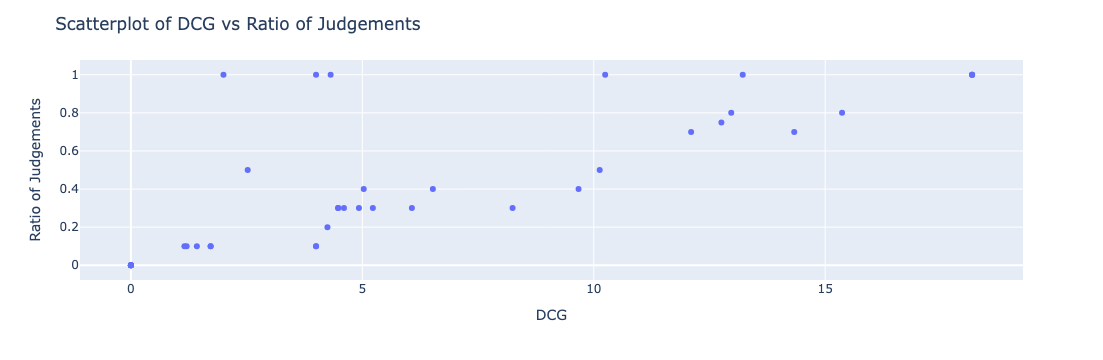

In [93]:
pio.renderers.default = 'plotly_mimetype'
fig = px.scatter(df_pivot, 
                 x='dcg', y='ratio_of_ratings', 
                 hover_data={'query': True},  # Show query on hover
                 labels={'dcg': 'DCG', 'ratio_of_ratings': 'Ratio of Judgements'})

# Customize the layout
fig.update_layout(title="Scatterplot of DCG vs Ratio of Judgements",
                  xaxis_title="DCG",
                  yaxis_title="Ratio of Judgements",
                  hovermode="closest")

# Show the plot
fig.show()